In [3]:

import icon_registration.networks as networks
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [5]:
from collections import OrderedDict
import torch.nn.functional as F
from icon_registration.mermaidlite import compute_warped_image_multiNC, identity_map_multiN
import torch
import random
import icon_registration.inverseConsistentNet as inverseConsistentNet
import icon_registration.network_wrappers as network_wrappers
import numpy as np
import matplotlib.pyplot as plt

In [6]:
r_ds = torch.load("/playpen/tgreer/knees_test_set_hires")
#batched_ds = list(zip(*[r_ds[i::4] for i in range(2)]))


In [7]:
2

2

In [8]:
batched_ds = list(zip(*[r_ds[i::2] for i in range(2)]))

In [10]:

phi = network_wrappers.FunctionFromVectorField(
    networks.tallUNet(unet=networks.UNet2ChunkyMiddle, dimension=3)
)
psi = network_wrappers.FunctionFromVectorField(networks.tallUNet2(dimension=3))

pretrained_lowres_net = network_wrappers.DoubleNet(phi, psi)

hires_net = network_wrappers.DoubleNet(
        network_wrappers.DownsampleNet(pretrained_lowres_net, dimension=3),
        network_wrappers.FunctionFromVectorField(networks.tallUNet2(dimension=3)),
    )

fourth_net = inverseConsistentNet.InverseConsistentNet(
    network_wrappers.DoubleNet(
        hires_net, 
        network_wrappers.FunctionFromVectorField(networks.tallUNet2(dimension=3)),
    ),  
    lambda x, y: (x - y) **2,
    3600,
)

BATCH_SIZE = 3
SCALE = 2  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
input_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

fourth_net.assign_identity_map(input_shape)
trained_weights = torch.load("../../masked_similarity_InvCon/results/fourth_net_frozen/knee_aligner_resi_net97800")
fourth_net.load_state_dict(trained_weights, strict=False)


_IncompatibleKeys(missing_keys=['identity_map', 'regis_net.identity_map', 'regis_net.netPhi.identity_map', 'regis_net.netPhi.netPhi.identity_map', 'regis_net.netPhi.netPhi.net.identity_map', 'regis_net.netPhi.netPhi.net.netPhi.identity_map', 'regis_net.netPhi.netPhi.net.netPsi.identity_map', 'regis_net.netPhi.netPsi.identity_map', 'regis_net.netPsi.identity_map'], unexpected_keys=['identityMap', 'regis_net.identityMap', 'regis_net.netPhi.identityMap', 'regis_net.netPhi.netPhi.identityMap', 'regis_net.netPhi.netPhi.net.identityMap', 'regis_net.netPhi.netPhi.net.netPhi.identityMap', 'regis_net.netPhi.netPhi.net.netPhi.net.identityMap', 'regis_net.netPhi.netPhi.net.netPsi.identityMap', 'regis_net.netPhi.netPhi.net.netPsi.net.identityMap', 'regis_net.netPhi.netPsi.identityMap', 'regis_net.netPhi.netPsi.net.identityMap', 'regis_net.netPsi.identityMap', 'regis_net.netPsi.net.identityMap'])

In [11]:
net = fourth_net

In [12]:
BATCH_SIZE = 2
network_wrappers.adjust_batch_size(net, BATCH_SIZE)
net.cuda()
net.eval()
0

/playpen-raid1/tgreer/ICON/src/icon_registration/network_wrappers.py:220: UserWarning: /tmp/ipykernel_39430/1021112945.py:2 - adjust_batch_size is deprecated. Batch size is now determined at runtime from input shape
  warnings.warn("%s:%d - %s" % (caller.filename, caller.lineno, message))


0

In [18]:
def flips(phi):
    a = phi[:, :, 1:, 1:, 1:] - phi[:, :, :-1, 1:, 1:]
    b = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, :-1, 1:]
    c = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, 1:, :-1]

    dV = torch.sum(torch.cross(a, b, 1) * c, axis=1, keepdims=True)
    return torch.sum(dV < 0)# / BATCH_SIZE
with torch.no_grad():
    dices = []
    folds_list = []
    
    filteredDV_list = []
    
    
    for x in batched_ds[:]:
        x = list(zip(*x))
        x = [torch.cat(r, 0).cuda().float() for r in x]
        fixed_image, fixed_cartilage = x[0], x[2]
        moving_image, moving_cartilage = x[1], x[3]

        net(moving_image, fixed_image)
        phi_AB_vectorfield = net.phi_AB(net.identity_map)
        fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(phi_AB_vectorfield[:, :3])
        sz = np.array(fat_phi.size())
        spacing = 1./(sz[2::]-1) 
        warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 0)
        wmb = warped_moving_cartilage == 2
        fb = fixed_cartilage == 2
        intersection = wmb * fb
        d = 2 * torch.sum(intersection, [1,2,3,4]).float() / (torch.sum(wmb, [1,2,3,4]) + torch.sum(fb, [1,2,3,4]))
        print(d)
        dices.append(d)
        f = flips(phi_AB_vectorfield[:1])
        print(f)
        folds_list.append(f.item())
        f = flips(phi_AB_vectorfield[1:])
        print(f)
        folds_list.append(f.item())
        
        #dV = flips2(phi_AB_vectorfield)
        
        #dV = np.array(dV).flatten()
        #dV = dV[dV < 0]
        #filteredDV_list.append(dV)
        
    dd = torch.mean(torch.cat(dices).cpu())
    print(dd)
    ff = np.mean(folds_list)
    print(ff)

tensor([0.7091, 0.7312], device='cuda:0')
tensor(2, device='cuda:0')
tensor(539, device='cuda:0')
tensor([0.6887, 0.6125], device='cuda:0')
tensor(8, device='cuda:0')
tensor(259, device='cuda:0')
tensor([0.5865, 0.5370], device='cuda:0')
tensor(70, device='cuda:0')
tensor(65, device='cuda:0')
tensor([0.7679, 0.6356], device='cuda:0')
tensor(72, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.6687, 0.7383], device='cuda:0')
tensor(10, device='cuda:0')
tensor(9, device='cuda:0')
tensor([0.5986, 0.7424], device='cuda:0')
tensor(14, device='cuda:0')
tensor(5, device='cuda:0')
tensor([0.7357, 0.6175], device='cuda:0')
tensor(2, device='cuda:0')
tensor(14, device='cuda:0')
tensor([0.7027, 0.6896], device='cuda:0')
tensor(49, device='cuda:0')
tensor(56, device='cuda:0')
tensor([0.6665, 0.6945], device='cuda:0')
tensor(156, device='cuda:0')
tensor(76, device='cuda:0')
tensor([0.6347, 0.5845], device='cuda:0')
tensor(31, device='cuda:0')
tensor(5, device='cuda:0')
tensor([0.5876, 0.7305],

tensor([0.6422, 0.6359], device='cuda:0')
tensor(247, device='cuda:0')
tensor(80, device='cuda:0')
tensor([0.7438, 0.6842], device='cuda:0')
tensor(25, device='cuda:0')
tensor(0, device='cuda:0')
tensor([0.7598, 0.6186], device='cuda:0')
tensor(74, device='cuda:0')
tensor(3, device='cuda:0')
tensor([0.5667, 0.6839], device='cuda:0')
tensor(120, device='cuda:0')
tensor(27, device='cuda:0')
tensor([0.5745, 0.6613], device='cuda:0')
tensor(491, device='cuda:0')
tensor(245, device='cuda:0')
tensor([0.5984, 0.7415], device='cuda:0')
tensor(582, device='cuda:0')
tensor(23, device='cuda:0')
tensor([0.7032, 0.6323], device='cuda:0')
tensor(165, device='cuda:0')
tensor(111, device='cuda:0')
tensor([0.6056, 0.6543], device='cuda:0')
tensor(13, device='cuda:0')
tensor(608, device='cuda:0')
tensor([0.4542, 0.7489], device='cuda:0')
tensor(10, device='cuda:0')
tensor(145, device='cuda:0')
tensor([0.6201, 0.6216], device='cuda:0')
tensor(24, device='cuda:0')
tensor(5, device='cuda:0')
tensor([0.6995

0.67534864
118.35


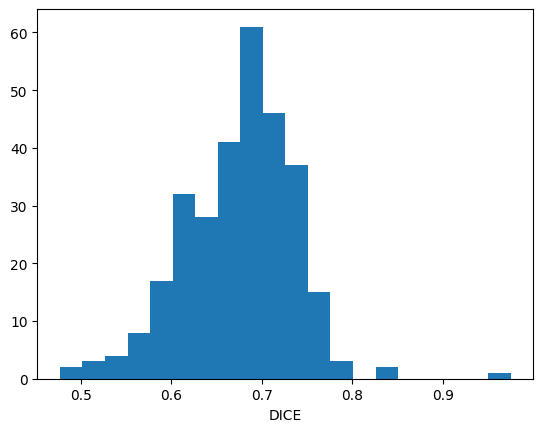

In [17]:
dicesa = np.array(torch.cat(dices).cpu())
plt.hist(dicesa, 20)
plt.xlabel("DICE")
print(np.mean(dicesa))
ff = np.mean(folds_list)
print(ff)

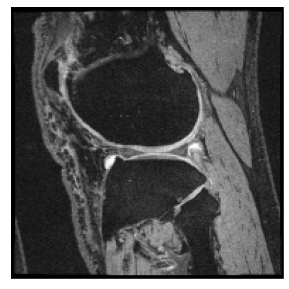

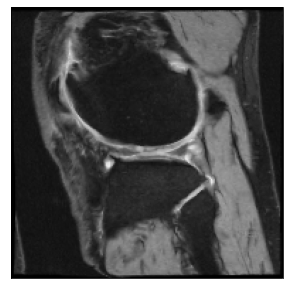

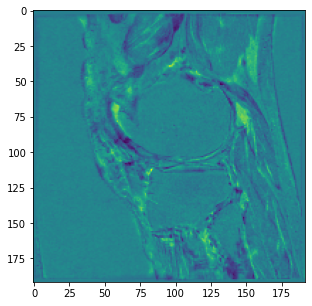

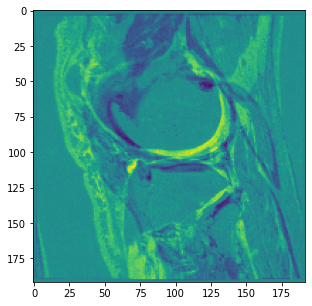

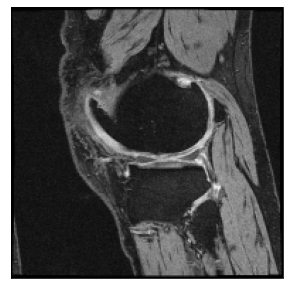

In [14]:



if not("N" in locals()):
    N = 0
#N += 1
N %= 2
#N = 3
#plt.imshow(fixed_image[N, 0, 10].cpu() - net.warped_image_A[N, 0, 10].cpu().detach())
#plt.show()
plt.rcParams["figure.figsize"] = (5, 5)
def imshow(x):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.abs(x.cpu().detach()), vmin=0, vmax=1, cmap="gray")
slice_ = 20
imshow(fixed_image[N, 0, slice_])
plt.show()
imshow(net.warped_image_A[N, 0, slice_])
plt.show()

plt.imshow(net.warped_image_B[N, 0, slice_ ].cpu().detach() - moving_image[N, 0, slice_ ].cpu().detach())
plt.show()
#plt.imshow(net.regis_net.x_comp_phi[N, 0, slice_].cpu().detach() - moving_image[N, 0, slice_].cpu().detach())
#plt.show()
plt.imshow((fixed_image - moving_image)[N, 0, slice_].cpu().detach())
plt.show()

imshow(moving_image[N, 0, slice_].cpu().detach())
plt.show()

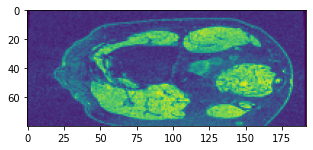

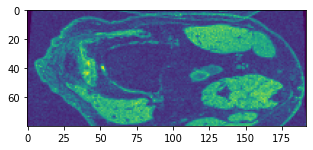

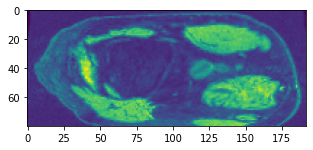

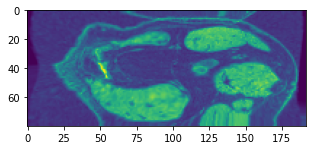

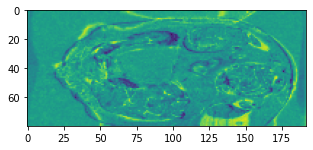

In [15]:
import matplotlib.pyplot as plt
plt.imshow(moving_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(fixed_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(net.warped_image_A[0, 0, :, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach())
plt.show()

plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach() - moving_image[0, 0, :, 10].cpu())

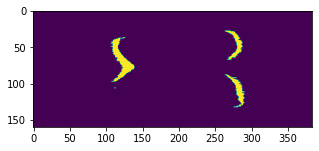

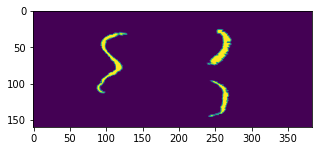

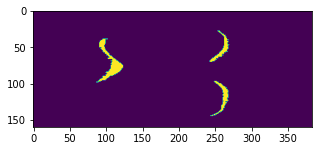

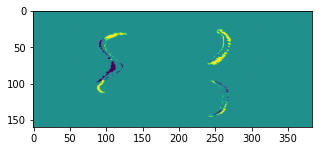

In [16]:

S = 40
plt.imshow(moving_cartilage[N, 0, :, S * 4].cpu())
plt.show() 
plt.imshow(warped_moving_cartilage[N, 0, :, S * 4].detach().cpu())
plt.show()

plt.imshow(fixed_cartilage[N, 0, :, S * 4].cpu())
plt.show()

plt.imshow((warped_moving_cartilage[N, 0, :, S * 4].detach().cpu() - fixed_cartilage[N, 0, :, S * 4].cpu()))
plt.show()

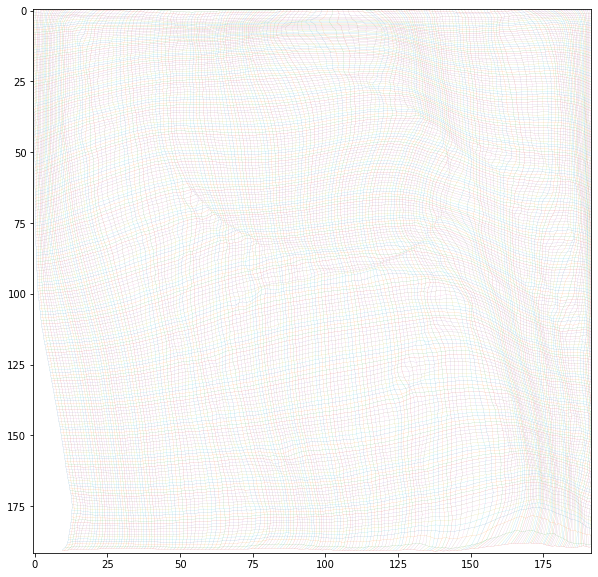

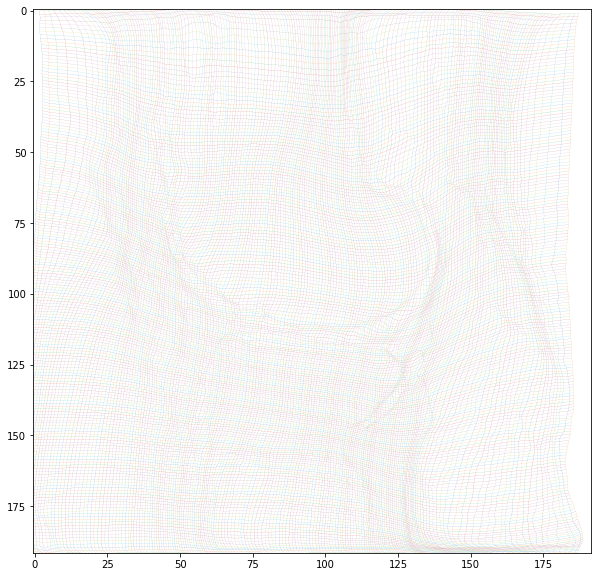

In [17]:
import visualize
N = (N + 1)% 2
#N = 1
plt.rcParams["figure.figsize"] = 10, 10
visualize.show_as_grid(net.phi_AB_vectorfield[N, [1, 2], 20])
plt.show()
visualize.show_as_grid(net.phi_BA_vectorfield[N, [1, 2], 20])


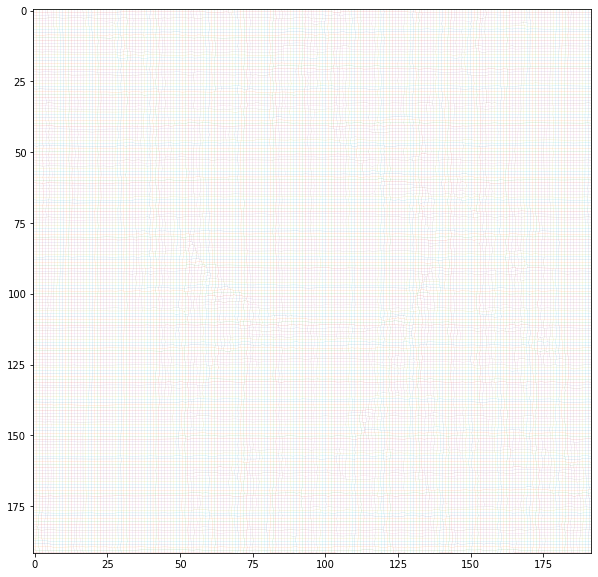

In [18]:
phi = net.phi_AB.__closure__[1]
some_vectorfield = phi.cell_contents.__closure__[1].cell_contents + net.identityMap
visualize.show_as_grid(some_vectorfield[N, [1, 2], 20])

In [19]:
net.phi_AB.__closure__[0].cell_contents

<function network_wrappers.DoubleNet.forward.<locals>.<lambda>(input_)>

In [20]:
N = (N + 1) % 4
visualize.show_as_grid(net.phi_BA(net.phi_AB(net.identityMap))[N, [1, 2], 20])

IndexError: index 2 is out of bounds for dimension 0 with size 2

In [21]:
import visualize
mp = hires_Net.phi_AB(hires_Net.regis_net.net.identityMap[:, :] + torch.tensor([[[[[0]]], [[[0]]], [[[0]]]]]).cuda())
visualize.show_as_grid(mp[N, [1, 2], 20])

NameError: name 'hires_Net' is not defined

In [22]:
import mermaidlite

In [23]:
import visualize
mp = pretrained_lowres_net.phi_AB(hires_Net.identityMap[:, :, ::2, ::2, ::2])
visualize.show_as_grid(mp[N, [1, 2], 20])

ModuleAttributeError: 'DoubleNet' object has no attribute 'phi_AB'

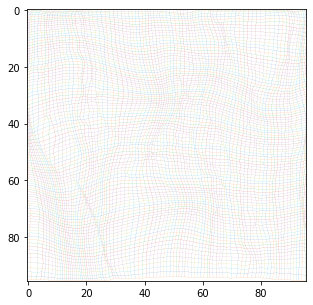

In [73]:
import visualize
mp = hires_Net.phi_BA(hires_Net.regis_net.net.identityMap)
visualize.show_as_grid(mp[N, [1, 2], 20])

In [44]:
mermaidlite.compute_warped_image_multiNC?

In [47]:
torch.nn.functional.avg_pool3d?

tensor([[[[[ 8.9085e-03,  9.2434e-03,  9.5800e-03,  ...,  8.9751e-03,
             9.2738e-03,  9.5502e-03],
           [ 9.2282e-03,  9.6274e-03,  1.0028e-02,  ...,  9.9777e-03,
             1.0269e-02,  1.0568e-02],
           [ 9.5437e-03,  1.0007e-02,  1.0471e-02,  ...,  1.0989e-02,
             1.1275e-02,  1.1593e-02],
           ...,
           [ 1.4196e-02,  1.4902e-02,  1.5630e-02,  ...,  3.1676e-02,
             3.1930e-02,  3.2242e-02],
           [ 1.4148e-02,  1.4913e-02,  1.5682e-02,  ...,  3.1702e-02,
             3.2031e-02,  3.2408e-02],
           [ 1.4288e-02,  1.5008e-02,  1.5746e-02,  ...,  3.1845e-02,
             3.2131e-02,  3.2459e-02]],

          [[ 2.1678e-02,  2.2050e-02,  2.2422e-02,  ...,  2.1415e-02,
             2.1756e-02,  2.2022e-02],
           [ 2.1997e-02,  2.2410e-02,  2.2823e-02,  ...,  2.2525e-02,
             2.2892e-02,  2.3150e-02],
           [ 2.2312e-02,  2.2766e-02,  2.3220e-02,  ...,  2.3641e-02,
             2.4040e-02,  2.4288e-02],
 

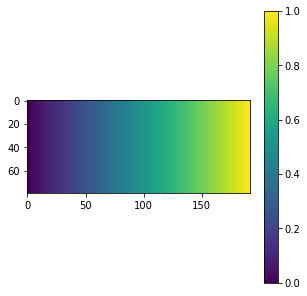

In [51]:
plt.imshow(hires_Net.identityMap[0, 2, :, 0].cpu().numpy())
plt.colorbar()

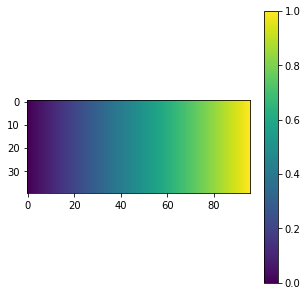

In [50]:
plt.imshow(net.identityMap[0, 2, :, 0].cpu().numpy())
plt.colorbar()

In [59]:
import importlib
import mermaidlite
importlib.reload(mermaidlite)

<module 'mermaidlite' from '/playpen-raid1/tgreer/InverseConsistency/mermaidlite.py'>

In [22]:
dir(net)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_module',
 'apply',
 'bfloat16',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval'

In [25]:
net(fixed_image, moving_image)

(tensor(0.0225, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(2.4185e-05, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0201, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0022, device='cuda:0', grad_fn=<MeanBackward0>))

In [27]:
weights_a = torch.load("../results/hires_continue_ramp_lambda3/knee_aligner_resi_net1200")
weights_b = torch.load("../results/hires_continue_ramp_lambda3/knee_aligner_resi_net9900")

In [44]:
weights_a["regis_net.netPsi.net.upConvs.2.weight"].shape

torch.Size([192, 64, 4, 4, 4])

tensor([-0.0072, -0.0064, -0.0167, -0.0075, -0.0135, -0.0068, -0.0109, -0.0210,
        -0.0091,  0.0195, -0.0205, -0.0089,  0.0141,  0.0079, -0.0024, -0.0181,
        -0.0125,  0.0085,  0.0196,  0.0138,  0.0020, -0.0112,  0.0030, -0.0125,
         0.0145,  0.0118,  0.0001, -0.0132, -0.0191, -0.0011, -0.0219,  0.0162],
       device='cuda:0')

In [40]:
weights_a.keys()

odict_keys(['identityMap', 'regis_net.identityMap', 'regis_net.netPsi.identityMap', 'regis_net.netPsi.net.identityMap', 'regis_net.netPsi.net.downConvs.0.weight', 'regis_net.netPsi.net.downConvs.0.bias', 'regis_net.netPsi.net.downConvs.1.weight', 'regis_net.netPsi.net.downConvs.1.bias', 'regis_net.netPsi.net.downConvs.2.weight', 'regis_net.netPsi.net.downConvs.2.bias', 'regis_net.netPsi.net.downConvs.3.weight', 'regis_net.netPsi.net.downConvs.3.bias', 'regis_net.netPsi.net.downConvs.4.weight', 'regis_net.netPsi.net.downConvs.4.bias', 'regis_net.netPsi.net.upConvs.0.weight', 'regis_net.netPsi.net.upConvs.0.bias', 'regis_net.netPsi.net.upConvs.1.weight', 'regis_net.netPsi.net.upConvs.1.bias', 'regis_net.netPsi.net.upConvs.2.weight', 'regis_net.netPsi.net.upConvs.2.bias', 'regis_net.netPsi.net.upConvs.3.weight', 'regis_net.netPsi.net.upConvs.3.bias', 'regis_net.netPsi.net.upConvs.4.weight', 'regis_net.netPsi.net.upConvs.4.bias', 'regis_net.netPsi.net.batchNorms.0.weight', 'regis_net.netPs

In [25]:
mkdir supll_regis_figures


In [59]:
import importlib
importlib.reload(visualize)
import matplotlib.colors as colors

for N in range(2):

    plt.rcParams["figure.figsize"] = (5, 5)
    def imshow(x):
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.abs(x.cpu().detach()), vmin=0, vmax=1, cmap="gray")
    offset = 0
    slice_ = 20
    
    for axis in ["Coronal", "Sagittal", "Axial"]:
        m_image = moving_image[N, 0].cpu().detach()
        f_image = fixed_image[N, 0].cpu().detach()
        m_warped_image_A = net.warped_image_A[N, 0].cpu().detach() 
        phi_BA = net.phi_BA_vectorfield[N]
        
        dV = flips2(net.phi_AB_vectorfield)[N, 0]
        
        if axis == "Sagittal":
            m_image_slice = m_image[slice_]
            f_image_slice = f_image[slice_]
            warped_image_A_slice = m_warped_image_A[slice_]
            phi_BA_slice = phi_BA[[1, 2], 20].clone()
            dV_slice = dV[slice_]
        if axis == "Coronal":
            m_image_slice = m_image[:, slice_].transpose(0, 1)
            f_image_slice = f_image[:, slice_].transpose(0, 1)
            warped_image_A_slice = m_warped_image_A[:, slice_].transpose(0, 1)
            phi_BA_slice = phi_BA[[2, 0], :, slice_].clone()
            phi_BA_slice[1] *= (79 / 181)
            dV_slice = dV[:, slice_].transpose(0, 1)
        if axis == "Axial":
            slice_ *= 2
            m_image_slice = m_image[:, :, slice_].transpose(0, 1)
            f_image_slice = f_image[:, :, slice_].transpose(0, 1)
            warped_image_A_slice = m_warped_image_A[:, :, slice_].transpose(0, 1)
            phi_BA_slice = phi_BA[[1, 0], :, :, slice_].clone()
            phi_BA_slice[1] *= (79 / 181)
            dV_slice = dV[:, :, slice_].transpose(0, 1)
            slice_ /= 2
            
            
        
        header = f"supll_regis_figures/{axis}Pair{N + offset}"
        imshow(m_image_slice)
        plt.savefig(header + "ImageA.png", bbox_inches="tight")
        plt.clf()
        imshow(f_image_slice)
        plt.savefig(header + "ImageB.png", bbox_inches="tight")
        plt.clf()
        imshow(warped_image_A_slice)
        plt.savefig(header + "WarpedImageA.png", bbox_inches="tight")
        plt.clf()
        imshow(warped_image_A_slice)
        visualize.show_as_grid(phi_BA_slice)
        plt.savefig(header + "WarpedImageAGrid.png", bbox_inches="tight")
        plt.clf()
        
        plt.xticks([])
        plt.yticks([])
        
        plt.imshow(dV_slice, norm=colors.LogNorm(vmin=torch.min(dV[dV > 0]), vmax=torch.max(dV)))
        plt.title("min dV is $\\bf{" + f"{np.min(dV_slice.numpy()):.3}" + "}$ in this slice", 
                 fontdict={'fontsize':13})
        plt.colorbar(label="dV")#, fraction=0.046, pad=0.04)
        #lt.show()
        #plt.imshow(dV[1, 0, 40] < 0)


        plt.savefig(header + "dV.png", bbox_inches="tight")
        plt.clf()
    """
    imshow(net.warped_image_B[N, 0, slice_ ].cpu().detach())
    plt.savefig(f"supll_regis_figures/Pair{N + offset}WarpedImageB.png")
    plt.clf()
    imshow(net.warped_image_B[N, 0, slice_].cpu().detach())
    visualize.show_as_grid(net.phi_AB_vectorfield[N, [1, 2], 20])
    plt.savefig(f"supll_regis_figures/Pair{N + offset}WarpedImageBGrid.png")
    plt.clf()
    """

    
    plt.show()

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

In [33]:
import importlib
importlib.reload(visualize)

<module 'visualize' from '/playpen-raid1/tgreer/InverseConsistency/visualize.py'>

In [11]:
def flips2(phi):
    a = phi[:, :, 1:, 1:, 1:] - phi[:, :, :-1, 1:, 1:]
    b = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, :-1, 1:]
    c = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, 1:, :-1]

    dV = torch.sum(torch.cross(a, b, 1) * c, axis=1, keepdims=True) / np.product(net.spacing)
    return dV.detach().cpu()

dV = flips2(net.phi_AB_vectorfield)

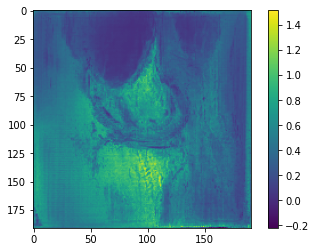

In [32]:
plt.imshow(torch.min(dV[1, 0], axis=0).values)
plt.colorbar()

In [34]:
torch.sum(dV[1] < 0)

tensor(13)

In [40]:
dV.shape

torch.Size([2, 1, 79, 191, 191])

In [49]:
116 / (80 * 192 * 192), 1 / 25000

(3.9333767361111114e-05, 4e-05)

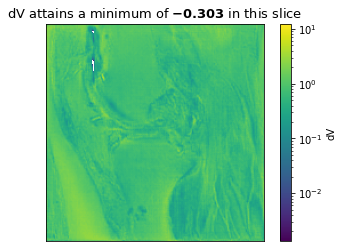

In [38]:
import matplotlib.colors as colors

plt.xticks([])
plt.yticks([])
query = dV[0, 0, 43]
plt.imshow(query, norm=colors.LogNorm(vmin=torch.min(dV[dV > 0]), vmax=torch.max(dV)))
plt.title("dV attains a minimum of $\\bf{" + f"{np.min(query.numpy()):.3}" + "}$ in this slice", 
         fontdict={'fontsize':13})
plt.colorbar(label="dV")#, fraction=0.046, pad=0.04)
#lt.show()
#plt.imshow(dV[1, 0, 40] < 0)


plt.savefig("dVslice0.pdf", bbox_inches="tight")


In [97]:
2 * np.sum(folds_list) / (np.product(list(dV.shape)) * len(r_ds))

2.046440866760003e-05

In [37]:
print("dV attains a minimum of $\\bf{" + f"{np.min(query.numpy()):.3}" + "}$ in this slice")
from matplotlib import rc
rc('text', usetex=False)
np.min(query.numpy())

dV attains a minimum of $\bf{0.0613}$ in this slice


0.061257

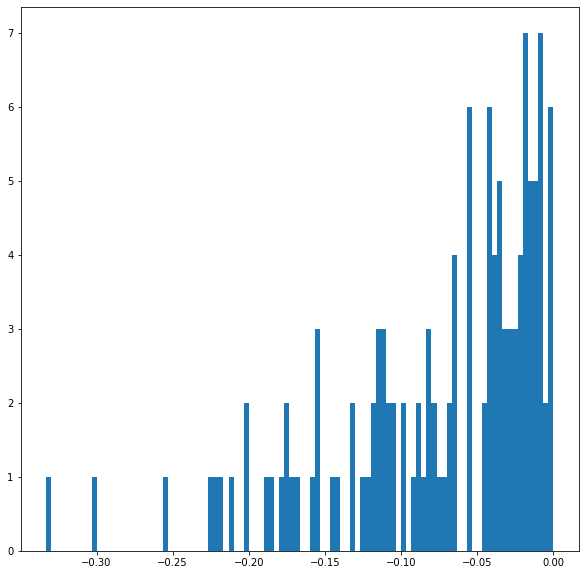

In [24]:
adv = np.array(dV)
filteredDV = adv[adv < 0.05]
plt.hist(filteredDV, bins=100)
plt.show()

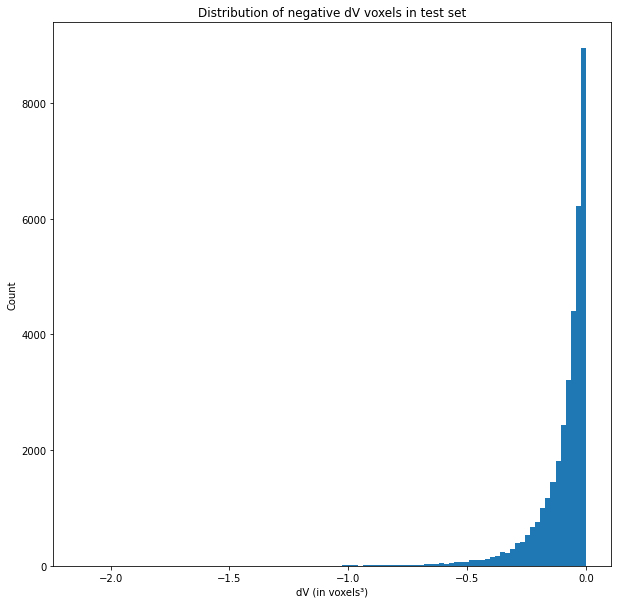

In [18]:
plt.hist(np.concatenate(filteredDV_list), bins=100)
plt.title("Distribution of negative dV voxels in test set")
plt.xlabel("dV (in voxels³)")
plt.ylabel("Count")
plt.savefig("DistributionNegativeJacobian.pdf")

In [26]:
np.mean(np.concatenate(filteredDV_list))

-0.09664285

In [27]:
np.median(np.concatenate(filteredDV_list))

-0.054298144

In [29]:
np.percentile(np.concatenate(filteredDV_list), 1)

-0.6120650005340577

In [28]:
%time net.regis_net(moving_image, fixed_image)

CPU times: user 18.3 ms, sys: 66.2 ms, total: 84.5 ms
Wall time: 58.8 ms


<function network_wrappers.DoubleNet.forward.<locals>.<lambda>(input_)>

In [6]:

with torch.no_grad():
    x = batched_ds[0]
    x = list(zip(*x))
    x = [torch.cat(r, 0).cuda().float() for r in x]
    fixed_image, fixed_cartilage = x[0], x[2]
    moving_image, moving_cartilage = x[1], x[3]
    

In [29]:
%%time
with torch.no_grad():
    phi = net.regis_net(moving_image, fixed_image)
    phi_AB_vectorfield = phi(net.identityMap).cpu()

CPU times: user 1.45 s, sys: 61 ms, total: 1.51 s
Wall time: 1.48 s


In [13]:
%%time 
net(moving_image, fixed_image)

CPU times: user 2.78 s, sys: 1.12 s, total: 3.9 s
Wall time: 3.83 s


(tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(5.5865e-05, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0568, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(6.9831e-06, device='cuda:0', grad_fn=<MeanBackward0>))

In [31]:
dV.shape

torch.Size([2, 1, 79, 191, 191])

In [22]:
net.input_shape

array([  4,   1,  80, 192, 192])

In [13]:
torch.onnx.export(net.regis_net.,               # model being run
                  (moving_image, fixed_image),                         # model input (or a tuple for multiple inputs)
                  "hires_network.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=12,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['image_a', 'image_b'],   # the model's input names
                  output_names = ['a', 'b', 'c', 'd'], # the model's output names
                  dynamic_axes={})

ModuleAttributeError: 'DoubleNet' object has no attribute 'psi'

(array([ 3.,  1.,  1.,  2.,  5.,  6.,  7., 10., 17., 22., 21., 26., 30.,
        40., 41., 29., 20.,  8.,  4.,  4.,  0.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([0.45836532, 0.47490254, 0.4914398 , 0.507977  , 0.52451426,
        0.54105145, 0.5575887 , 0.5741259 , 0.59066314, 0.6072004 ,
        0.6237376 , 0.6402748 , 0.6568121 , 0.67334926, 0.6898865 ,
        0.70642376, 0.72296095, 0.7394982 , 0.7560354 , 0.77257264,
        0.7891099 , 0.8056471 , 0.8221843 , 0.8387216 , 0.85525876,
        0.871796  , 0.8883332 , 0.90487045, 0.9214077 , 0.9379449 ,
        0.95448214], dtype=float32),
 <BarContainer object of 30 artists>)

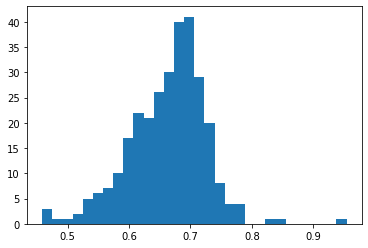

In [27]:
plt.hist(torch.cat(dices).cpu().detach().numpy(), bins=30)

In [26]:
torch.cat(dices).cpu().shape

torch.Size([300])

In [10]:
%%sh
scp biag-gpu0:/playpen/tgreer/knees_test_set_hires /playpen/tgreer/knees_test_set_hires 


The Department of Computer Science at UNC Chapel Hill.
This system is intended for use by department affiliates only.
Unauthorized access to this system is prohibited.

Permission denied, please try again.
Permission denied, please try again.
tgreer@biag-gpu0: Permission denied (publickey,gssapi-keyex,gssapi-with-mic,password).


CalledProcessError: Command 'b'scp biag-gpu0:/playpen/tgreer/knees_test_set_hires /playpen/tgreer/knees_test_set_hires \n'' returned non-zero exit status 1.

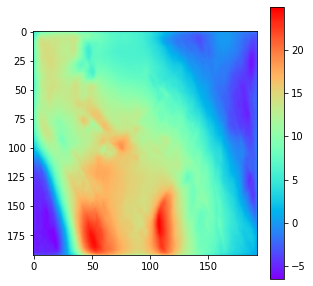

In [29]:
pixel_displacement = ((net.phi_AB_vectorfield.cpu() - net.identityMap.cpu()) 
    * torch.tensor(net.phi_AB_vectorfield.shape)[None, 2:, None, None, None])
plt.imshow(pixel_displacement[0, 2, 40], cmap="rainbow")
plt.colorbar()

In [133]:
torch.max(torch.abs(pixel_displacement))

tensor(30.6417)

In [145]:
error = (net.phi_AB(net.phi_BA_vectorfield) - net.identityMap).cpu()* torch.tensor(net.phi_AB_vectorfield.shape)[None, 2:, None, None, None]

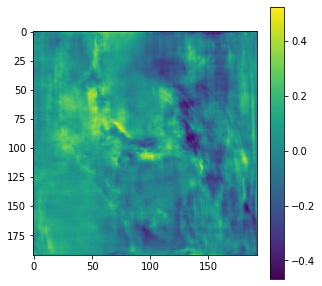

In [146]:
plt.imshow((error)[0, 0, 40])
plt.colorbar()

In [148]:
torch.sqrt(torch.mean(error**2))

tensor(0.3200)

In [173]:
plt.rcParams["figure.figsize"]

[6.4, 4.8]

Text(0, 0.5, 'number of image pairs')

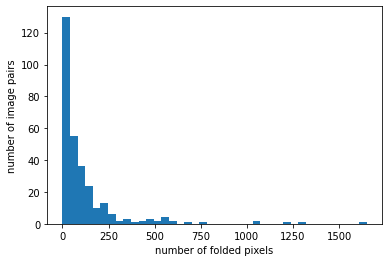

In [58]:
plt.hist(folds_list, bins=40)
plt.xlabel("number of folded pixels")
plt.ylabel("number of image pairs")

In [31]:
for x in range(3):
    y = 7
y

7

In [49]:
dV.shape


torch.Size([79, 191, 191])